In [1]:
import clip
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import os
import csv
import numpy as np

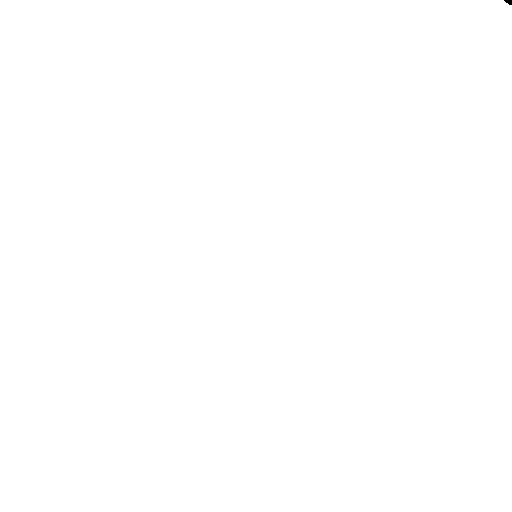

In [11]:
img = Image.open('/hy-tmp/6000_outputs/bef80974bf024801_m021mn_cf850b40_mask.png')
img

In [2]:
class InferenceDataset(Dataset):
    def __init__(self, datadir, inference_dir, test_scene, clip_preprocess, seed, eval_resolution=256, img_suffix='.jpg', inpainted_suffix='_removed.png'):
        self.inference_dir = inference_dir
        self.datadir = datadir
        if not datadir.endswith('/'):
            datadir += '/'
        self.mask_filenames = sorted(list(glob.glob(os.path.join(self.datadir, '**', '*mask*.png'), recursive=True)))
        self.img_filenames = [fname.rsplit('_mask', 1)[0] + img_suffix for fname in self.mask_filenames]
        self.file_names_seed1 = [os.path.join(inference_dir, os.path.splitext(fname[len(datadir):])[0] + inpainted_suffix + str(seed[0]) + '.png')
                                for fname in self.img_filenames]
        self.file_names_seed2 = [os.path.join(inference_dir, os.path.splitext(fname[len(datadir):])[0] + inpainted_suffix + str(seed[1]) + '.png')
                                for fname in self.img_filenames]
        self.file_names_seed3 = [os.path.join(inference_dir, os.path.splitext(fname[len(datadir):])[0] + inpainted_suffix + str(seed[2]) + '.png')
                                for fname in self.img_filenames]
        
        self.clip_preprocess = clip_preprocess
        self.eval_resolution = eval_resolution
        self.test_scene = self.read_csv_to_dict(test_scene)
        self.ids = [file_name.rsplit('/', 1)[1].rsplit('_mask.png', 1)[0] for file_name in self.mask_filenames]

        self.collect_all_classes()

    def __len__(self):
        return len(self.ids)


    def read_csv_to_dict(self,file_path):
        data_dict = {}
        
        with open(file_path, 'r', encoding='utf-8') as file:
            reader = csv.reader(file, delimiter=',')
            header = next(reader)  # Skip header if there is one
            for row in reader:
                id = row[0].rsplit('.', 1)[0]
                LabelName = row[1]
                BoxXMin = float(row[2])
                BoxXMax = float(row[3])
                BoxYMin = float(row[4])
                BoxYMax = float(row[5])
                
                data_dict[id] = {
                    'LabelName': LabelName,
                    'BoxXMin': BoxXMin,
                    'BoxXMax': BoxXMax,
                    'BoxYMin': BoxYMin,
                    'BoxYMax': BoxYMax
                }
                
        return data_dict

    def scale_box(self, box, scale_ratio):
        return list(map(lambda x: int(x * scale_ratio), box))

    def get_cropped_boundary(self, object_bbox, image_size_orig):
        width, height = image_size_orig
        min_size = min(image_size_orig)
        object_bbox[0] -= (width - min_size) // 2
        object_bbox[1] -= (height - min_size) // 2
        object_bbox[2] -= (width - min_size) // 2
        object_bbox[3] -= (height - min_size) // 2
        object_bbox = np.clip(object_bbox, 0, min_size)
        return object_bbox

    def get_scaled_boundary(self, object_bbox, scale_ratio):
        object_bbox = np.array(self.scale_box(object_bbox, scale_ratio))
        return object_bbox

    def read_image(self, path):
        img = Image.open(path).resize((self.eval_resolution,self.eval_resolution), Image.Resampling.BILINEAR)
        return img

    def collect_all_classes(self):
        classes = set()
        for scene_id in self.ids:
            classes.add(self.test_scene[scene_id]["LabelName"])
        self.classes = list(classes)

    def add_padding(self, image):	
        padding_color = (0,0,0)
        width, height = image.size	
        if width > height:	
            padded_image = Image.new(image.mode, (width, width), padding_color)	
            padded_image.paste(image, (0, (width - height) // 2))	
        else:	
            padded_image = Image.new(image.mode, (height, height), padding_color)	
            padded_image.paste(image, ((height - width) // 2, 0))	
        return padded_image

    def __getitem__(self, idx):
        scene_id = self.ids[idx]
        object_bbox = (int(self.test_scene[scene_id]["BoxXMin"]*self.eval_resolution),
                       int(self.test_scene[scene_id]["BoxYMin"]*self.eval_resolution),
                       int(self.test_scene[scene_id]["BoxXMax"]*self.eval_resolution),
                       int(self.test_scene[scene_id]["BoxYMax"]*self.eval_resolution))
        object_name = self.test_scene[scene_id]["LabelName"]

        source_image = self.read_image(self.img_filenames[idx])

        inpainted_image_seed1 = self.read_image(self.file_names_seed1[idx])
        inpainted_image_seed2 = self.read_image(self.file_names_seed2[idx])
        inpainted_image_seed3 = self.read_image(self.file_names_seed3[idx])
        
        #object_bbox = self.get_cropped_boundary(object_bbox, image_size_orig)
        
        #scale_ratio =  self.eval_resolution / min(image_size_orig)
        #object_bbox = np.array(self.scale_box(object_bbox, scale_ratio))
        return (
            self.clip_preprocess(self.add_padding(source_image.crop(object_bbox))),	
            self.clip_preprocess(self.add_padding(inpainted_image_seed1.crop(object_bbox))),
            self.clip_preprocess(self.add_padding(inpainted_image_seed2.crop(object_bbox))),
            self.clip_preprocess(self.add_padding(inpainted_image_seed3.crop(object_bbox))),
            object_name,
            scene_id,
        )

In [2]:
class CLIPMetric:
    def __init__(self, model_name="ViT-B/32", device="cuda"):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        model, preprocess = clip.load(model_name, device=self.device)
        self.model = model.eval()
        self.preprocess = preprocess

    def score(self, images, texts):
        images = images.to(self.device)
        
        # 确保texts是一个list
        if not isinstance(texts, list):
            texts = [texts]

        scores = []
        for img, text in zip(images, texts):
            text_tokenized = clip.tokenize(text).to(self.device)
            img = img.unsqueeze(0).to(self.device)  # 添加批次维度

            with torch.no_grad():
                logits_per_image, logits_per_text = self.model(img, text_tokenized)

            scores.append(logits_per_image.squeeze().cpu().numpy())
        # 将每个NumPy数组转换为PyTorch张量
        tensor_list = [torch.tensor(arr) for arr in scores]

        # 将这些张量堆叠为一个新的张量
        stacked_tensor = torch.stack(tensor_list)

        # 调整形状为[4, 1]
        final_tensor = stacked_tensor.unsqueeze(1)
        return final_tensor
    
    def calculate_clip_consensus(self, images):  
        std = []
        for img_seed1,img_seed2,img_seed3 in zip(*images):
            img_seeds = [img_seed1, img_seed2, img_seed3]
            embeddings = []
            for image in img_seeds:
                image = image.unsqueeze(0).to(self.device)
                with torch.no_grad():
                    image_features = self.model.encode_image(image)
                embeddings.append(image_features.cpu().numpy())

            # 将嵌入堆叠成一个numpy数组
            embeddings = np.vstack(embeddings)
            
            # 计算嵌入的标准差
            consensus_std = np.std(embeddings, axis=0)
            std.append(consensus_std.mean())
        # 将每个NumPy数组转换为PyTorch张量
        tensor_list = [torch.tensor(arr) for arr in std]

        # 将这些张量堆叠为一个新的张量
        stacked_tensor = torch.stack(tensor_list)

        # 调整形状为[4, 1]
        final_tensor = stacked_tensor.unsqueeze(1)
        # 返回标准差的均值作为CLIP consensus指标
        return final_tensor

In [88]:
clip_metric = CLIPMetric(model_name="ViT-B/32")

dataset = InferenceDataset('/hy-tmp/100_outputs', '/hy-tmp/100_outputs', '/hy-tmp/DATA/fetch_output_100.csv', 
                           clip_metric.preprocess, 
                           seed = [123,321,777],
                           eval_resolution=512, 
                           img_suffix='.png', 
                           inpainted_suffix='_removed_')
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [110]:
inference_scores = {}
scene_ids = []

In [111]:
for idx, (source_img, inpainted_image_seed1, inpainted_image_seed2, inpainted_image_seed3, object_names, scene_id) in enumerate(dataloader):
    scene_ids.extend(list(scene_id))
    prompts = list(map(lambda x: f"a photo of a {x}", object_names))
    src_scores = clip_metric.score(source_img, prompts)
    prd_scores_seed1  = clip_metric.score(inpainted_image_seed1, prompts)
    prd_scores_seed2  = clip_metric.score(inpainted_image_seed2, prompts)
    prd_scores_seed3  = clip_metric.score(inpainted_image_seed3, prompts)
    prd_scores_mean = (prd_scores_seed1 + prd_scores_seed2 + prd_scores_seed3)/3
    prd_clip_consensus = clip_metric.calculate_clip_consensus([inpainted_image_seed1, inpainted_image_seed2, inpainted_image_seed3])
    for src_score, prd_seed1 , prd_seed2, prd_seed3, mean, prd_consensus, id in zip(src_scores, prd_scores_seed1, prd_scores_seed2, prd_scores_seed3, prd_scores_mean, prd_clip_consensus, scene_id):
        inference_scores[id] = {
            "src_scores": src_score,
            "prd_scores_seed1": prd_seed1,
            "prd_scores_seed2": prd_seed2,
            "prd_scores_seed3": prd_seed3,
            "prd_scores_mean": mean,
            "prd_clip_consensus": prd_consensus,
            "my_metric": (src_score - mean)/prd_consensus
        }
    break


In [112]:
scene_ids

['019877aafb67d078_m0306r_83131dfa',
 '022c71451277faa4_m08pbxl_19b2c72c',
 '050e9d0a85a62229_m0jy4k_874c4dda',
 '080014db39bc64ea_m03c7gz_a7ecabab']

In [7]:
clip_metric = CLIPMetric(model_name="ViT-B/32")

In [20]:
img = Image.open('/hy-tmp/6000_outputs/0aed7fafa7ade4c7_m04yx4_ddbbf1ea.png').resize((512,512), Image.Resampling.BILINEAR)
img_rm = Image.open('/hy-tmp/6000_outputs/0aed7fafa7ade4c7_m04yx4_ddbbf1ea_ori_123.png').resize((512,512), Image.Resampling.BILINEAR)
img_inp = Image.open('/hy-tmp/inp_outputs_6000/0aed7fafa7ade4c7_m04yx4_ddbbf1ea_ori_123.png').resize((512,512), Image.Resampling.BILINEAR)
img_sd = Image.open('/hy-tmp/sd_outputs_6000/0aed7fafa7ade4c7_m04yx4_ddbbf1ea_ori_123.png').resize((512,512), Image.Resampling.BILINEAR)
img_lama = Image.open('/hy-tmp/lama_6000/0aed7fafa7ade4c7_m04yx4_ddbbf1ea_removed.png').resize((512,512), Image.Resampling.BILINEAR)
object_name = 'Man'
BoxXMin = 0.090147
BoxXMax = 0.614256
BoxYMin = 0.059098
BoxYMax = 1.000000
object_bbox = (int(BoxXMin*512),
                int(BoxYMin*512),
                int(BoxXMax*512),
                int(BoxYMax*512))
source_img = clip_metric.preprocess(img.crop(object_bbox)).unsqueeze(0)
rm_img = clip_metric.preprocess(img_rm.crop(object_bbox)).unsqueeze(0)
inp_img = clip_metric.preprocess(img_inp.crop(object_bbox)).unsqueeze(0)
sd_img = clip_metric.preprocess(img_sd.crop(object_bbox)).unsqueeze(0)
lama_img = clip_metric.preprocess(img_lama.crop(object_bbox)).unsqueeze(0)
prompt = f"A photo of a {object_name}"

In [21]:
src_scores = clip_metric.score(source_img, prompt)
print(f"source:{src_scores.item()}")
#w_scores = clip_metric.score(source_img, "A photo of a backgroud")
#print(w_scores) 
prd_scores = clip_metric.score(rm_img, prompt)
print(f"rm_prompt:{prd_scores.item()}")
prd_w_scores = clip_metric.score(rm_img, "backgroud")
print(f"rm_bk:{prd_w_scores.item()}")
prd_scores_lama = clip_metric.score(lama_img, prompt)
print(f"lama_prompt:{prd_scores_lama.item()}")
prd_w_scores_lama = clip_metric.score(lama_img, "backgroud")
print(f"lama_bk:{prd_w_scores_lama.item()}")
prd_scores_inp = clip_metric.score(inp_img, prompt)
print(f"inp_prompt:{prd_scores_inp.item()}")
prd_w_scores_inp = clip_metric.score(inp_img, "backgroud")
print(f"inp_bk:{prd_w_scores_inp.item()}")
prd_scores_sd = clip_metric.score(sd_img, prompt)
print(f"sd_prompt:{prd_scores_sd.item()}")
prd_w_scores_sd = clip_metric.score(sd_img, "backgroud")
print(f"sd_bk:{prd_w_scores_sd.item()}")

source:25.59375
rm_prompt:24.125
rm_bk:23.421875
lama_prompt:21.765625
lama_bk:22.984375
inp_prompt:22.09375
inp_bk:21.671875
sd_prompt:23.25
sd_bk:21.5625


In [15]:
src_scores = clip_metric.score(source_img, prompt)
print(f"source:{src_scores.item()}")
#w_scores = clip_metric.score(source_img, "A photo of a backgroud")
#print(w_scores) 
prd_scores = clip_metric.score(rm_img, prompt)
print(f"rm_prompt:{prd_scores.item()}")
prd_w_scores = clip_metric.score(rm_img, "A photo of a backgroud")
print(f"rm_bk:{prd_w_scores.item()}")
prd_scores_inp = clip_metric.score(inp_img, prompt)
print(f"inp_prompt:{prd_scores_inp.item()}")
prd_w_scores_inp = clip_metric.score(inp_img, "A photo of a backgroud")
print(f"inp_bk:{prd_w_scores_inp.item()}")
prd_scores_sd = clip_metric.score(sd_img, prompt)
print(f"sd_prompt:{prd_scores_sd.item()}")
prd_w_scores_sd = clip_metric.score(sd_img, "A photo of a backgroud")
print(f"sd_bk:{prd_w_scores_sd.item()}")

source:25.59375
rm_prompt:24.125
rm_bk:24.609375
inp_prompt:22.09375
inp_bk:22.890625
sd_prompt:23.25
sd_bk:22.515625


# clip_consensus

In [13]:
import torch
import clip
from PIL import Image
import numpy as np

def calculate_clip_consensus(image_paths):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 加载CLIP模型和预处理函数
    model, preprocess = clip.load("ViT-B/32", device=device)

    embeddings = []
    scores = []
    BoxXMin = 0.026608
    BoxXMax = 0.895787
    BoxYMin = 0.171806
    BoxYMax = 1.000000
    object_bbox = (int(BoxXMin*512),
                    int(BoxYMin*512),
                    int(BoxXMax*512),
                    int(BoxYMax*512))
    prompt = "A photo of a women"
    for image_path in image_paths:
        # 预处理图像
        image = preprocess(Image.open(image_path).crop(object_bbox)).unsqueeze(0).to(device)
        text = clip.tokenize(prompt).to(device)
        
        # 计算图像嵌入
        with torch.no_grad():
            image_features = model.encode_image(image)
            logits_per_image, logits_per_text = model(image, text)
        embeddings.append(image_features.cpu().numpy())
        scores.append(logits_per_image.cpu().numpy())
    # 将嵌入堆叠成一个numpy数组
    embeddings = np.vstack(embeddings)
    scores_np = np.vstack(scores)
    
    # 计算嵌入的标准差
    consensus_std = np.std(embeddings, axis=0)
    #score_mean = np.mean(scores_np, axis=0)
    # 返回标准差的均值作为CLIP consensus指标
    return consensus_std.mean(),scores,scores_np.mean()


In [17]:
# 示例图片路径
image_paths = ["/hy-tmp/100_outputs/0a9fd00665d365a8_m03bt1vf_15f4a879_removed_123.png", 
               "/hy-tmp/100_outputs/0a9fd00665d365a8_m03bt1vf_15f4a879_removed_321.png", 
               "/hy-tmp/100_outputs/0a9fd00665d365a8_m03bt1vf_15f4a879_removed_777.png"]

# 计算CLIP consensus指标
consensus_score,scores,scores_mean = calculate_clip_consensus(image_paths)
print(f"CLIP Consensus Score: {consensus_score}")
print(f"CLIP Scores: {scores}")
print(f"CLIP Scores Mean: {scores_mean}")
print(f"m:{scores_mean/consensus_score}")

CLIP Consensus Score: 0.0694580078125
CLIP Scores: [array([[21.66]], dtype=float16), array([[23.05]], dtype=float16), array([[22.45]], dtype=float16)]
CLIP Scores Mean: 22.390625
m:322.25


In [20]:
# 示例图片路径
image_paths = ["/hy-tmp/inp_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_123.png", 
               "/hy-tmp/inp_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_321.png", 
               "/hy-tmp/inp_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_777.png"]

# 计算CLIP consensus指标
consensus_score,scores,scores_mean = calculate_clip_consensus(image_paths)
print(f"CLIP Consensus Score: {consensus_score}")
print(f"CLIP Scores: {scores}")
print(f"CLIP Scores Mean: {scores_mean}")
print(f"m:{scores_mean/consensus_score}")


CLIP Consensus Score: 0.1376953125
CLIP Scores: [array([[21.36]], dtype=float16), array([[25.94]], dtype=float16), array([[25.34]], dtype=float16)]
CLIP Scores Mean: 24.21875
m:175.875


In [21]:
# 示例图片路径
image_paths = ["/hy-tmp/sd_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_123.png", 
               "/hy-tmp/sd_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_321.png", 
               "/hy-tmp/sd_outputs_100/0a9fd00665d365a8_m03bt1vf_15f4a879_inp_777.png"]

# 计算CLIP consensus指标
consensus_score,scores,scores_mean = calculate_clip_consensus(image_paths)
print(f"CLIP Consensus Score: {consensus_score}")
print(f"CLIP Scores: {scores}")
print(f"CLIP Scores Mean: {scores_mean}")
print(f"m:{scores_mean/consensus_score}")

CLIP Consensus Score: 0.181640625
CLIP Scores: [array([[20.16]], dtype=float16), array([[20.72]], dtype=float16), array([[24.14]], dtype=float16)]
CLIP Scores Mean: 21.671875
m:119.3125
